In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from read_fk_table import get_fk_table
from read_faserv_pdf import read_pdf
from read_LHEF import read_LHEF_data
from data_errors import compute_errors
from MC_data_reps import generate_MC_replicas

In [2]:
# Define global variables
num_obs = 3 #between 1 and 4
REPLICAS  = 2

In [3]:
# Read data
data, data_min,data_max ,xvals_per_obs, binwidths,xlabels, events_per_obs =read_LHEF_data(num_obs)
#Get errors
sig_sys,sig_tot, cov_matrix = compute_errors(data,data_min,data_max,num_obs)    

#Generate MC replicas of data
MC_data,data_level1 = generate_MC_replicas(REPLICAS,num_obs,data,sig_sys)

    
# Get FK tables
x_alphas, fk_tables,mask = get_fk_table(num_obs)

# Get faserv pdf
pdf = "faserv"
lowx = -8
n=250
faser_pdf,x_faser = read_pdf(pdf,lowx,n)


LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


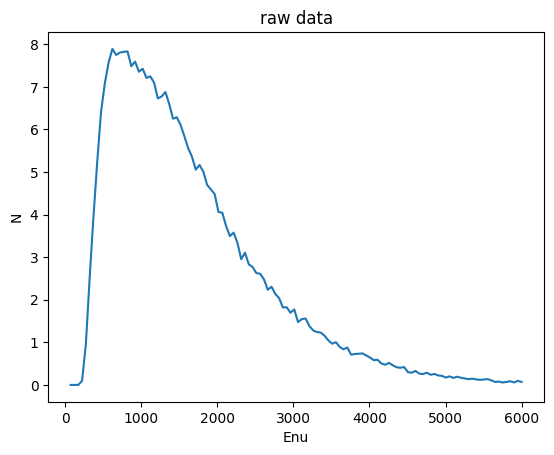

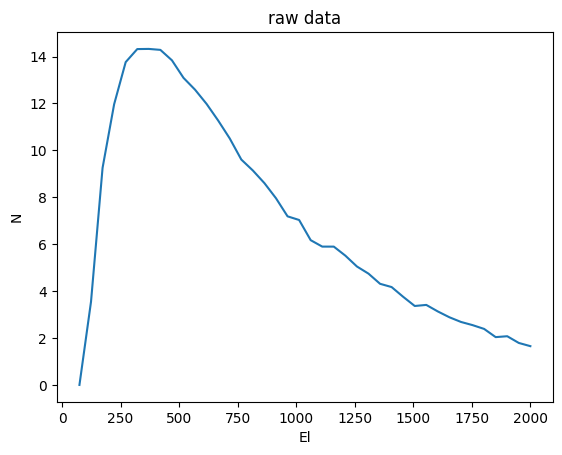

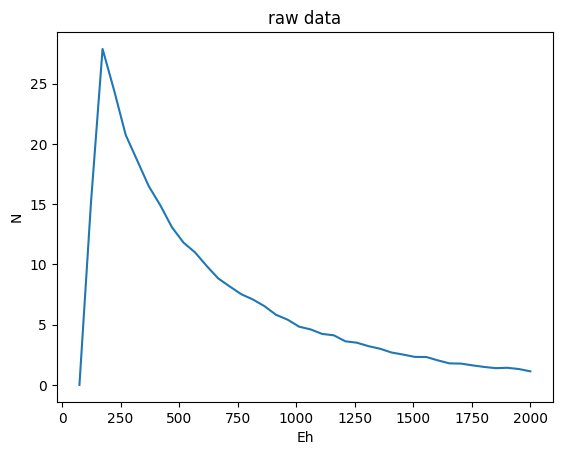

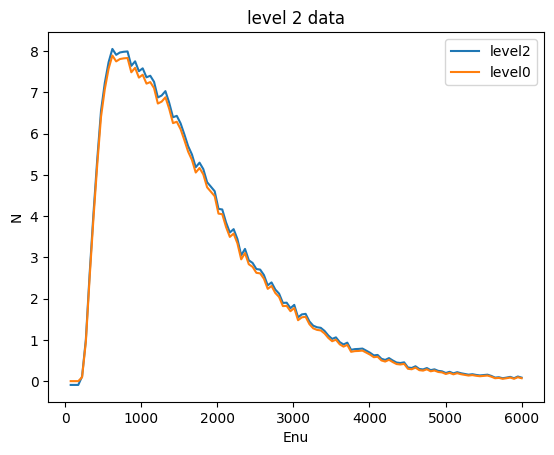

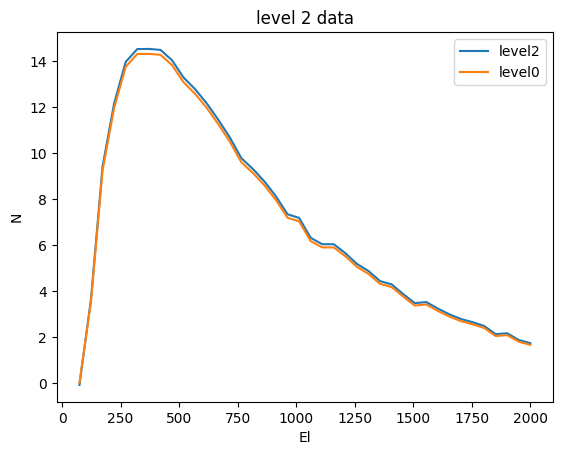

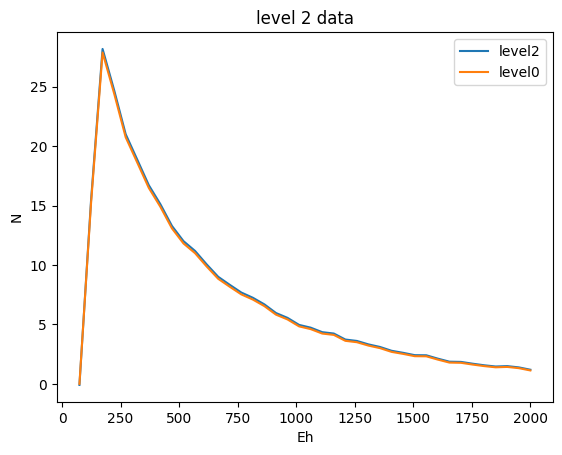

In [4]:

for i in range(num_obs):
    plt.plot(xvals_per_obs[i],events_per_obs[i])
    plt.xlabel(xlabels[i])
    plt.ylabel('N')
    plt.title("raw data")
    plt.show()


start = 0
for i in range(num_obs):
    plt.plot(
        xvals_per_obs[i], MC_data[0][start : len(events_per_obs[i]) + start], label="level2"
    )
    plt.plot(xvals_per_obs[i], events_per_obs[i],label="level0")
    plt.xlabel(xlabels[i])
    plt.legend()
    plt.ylabel("N")
    plt.title("level 2 data")
    plt.show()
    start += len(events_per_obs[i])




In [5]:
class SimplePerceptron(torch.nn.Module):
    def __init__(self, l1,l2,l3):
        super(SimplePerceptron, self).__init__()
        self.linear = torch.nn.Linear(1,l1)
        self.hidden = torch.nn.Linear(l1,l2)
        self.hidden2 = torch.nn.Linear(l2,l3)
        self.hidden3 = torch.nn.Linear(l3,1)
        self.relu = torch.nn.ReLU()

    def forward(self, y):
        y = self.linear(y)
        y = self.relu(y)
        y = self.hidden(y)
        y = self.relu(y)
        y = self.hidden2(y)
        y = self.relu(y)
        y = self.hidden3(y)
    
        return y

In [6]:
# import torch.nn as nn
# class CustomPreprocessing(nn.Module):
#     def __init__(self, alpha,beta,gamma):
#         super(CustomPreprocessing, self).__init__()
#         self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
#         self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
#         self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))

#     def forward(self, x):
#         return self.gamma*(1 - x) ** self.beta * x ** (1 - self.alpha)

In [7]:
import torch.nn as nn
class CustomPreprocessing(nn.Module):
    def __init__(self, alpha):
        super(CustomPreprocessing, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
    def forward(self, x):
        return self.alpha*x

In [8]:
# import torch.nn as nn
# class CustomPreprocessing(nn.Module):
#     def __init__(self, alpha,beta,gamma,a,epsilon):
#         super(CustomPreprocessing, self).__init__()
#         self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
#         self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
#         self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))
#         self.a = nn.Parameter(torch.tensor(a, dtype=torch.float32, requires_grad=True))
#         self.epsilon = nn.Parameter(torch.tensor(epsilon, dtype=torch.float32, requires_grad=True))

#     def forward(self, x):
#         return self.a * x**(-self.alpha) * (1-x)**self.beta * (1+self.epsilon*x**0.5 + self.gamma*x)

In [9]:
# Combine the preprocessing and MLP in a single model

class PreprocessedMLP(nn.Module):
    def __init__(self, alpha,l1, l2, l3):
        super(PreprocessedMLP, self).__init__()
        self.preprocessing = CustomPreprocessing(alpha)
        self.mlp = SimplePerceptron(l1, l2, l3)

    def forward(self, x):
        x = self.preprocessing(x)
        x = self.mlp(x)
        return x
# class PreprocessedMLP(nn.Module):
#     def __init__(self, alpha, beta, gamma,l1, l2, l3):
#         super(PreprocessedMLP, self).__init__()
#         self.preprocessing = CustomPreprocessing(alpha, beta,gamma)
#         self.mlp = SimplePerceptron(l1, l2, l3)

#     def forward(self, x):
#         x = self.preprocessing(x)
#         x = self.mlp(x)
#         return x

# class PreprocessedMLP(nn.Module):
#     def __init__(self, alpha, beta, gamma,a,epsilon,l1, l2, l3):
#         super(PreprocessedMLP, self).__init__()
#         self.preprocessing = CustomPreprocessing(alpha, beta,gamma,a,epsilon)
#         self.mlp = SimplePerceptron(l1, l2, l3)

#     def forward(self, x):
#         x = self.preprocessing(x)
#         x = self.mlp(x)
#         return x

In [10]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()
    def forward(self,pred,data):
        lag_mult = 10
        diff = pred - data  
        loss = torch.matmul(cov_matrix, diff)  

        loss = (1 / pred.size(0)) * torch.dot(diff.view(-1), loss.view(-1)) + 1
        loss[loss < 0] *= lag_mult * (np.exp([loss < 0]) - 1)
        
        return loss

In [11]:
x_alpha_more_bins = np.logspace(-5,0,1000)
x_alpha_more_bins = torch.tensor(x_alpha_more_bins, dtype=torch.float32).view(-1,1)
x_fit = np.logspace(-5,0,1000)

neutrino_pdfs = []
N_event_pred = np.zeros((REPLICAS), dtype=object)

In [12]:
for i in range(REPLICAS):

    alpha = 10

    # alpha = -2
    # beta = 40  
    # gamma = 10000

    # alpha = -1.5  # Example alpha value
    # beta = 26  # Example beta value
    # gamma = 1
    # epsilon=2000
    # a=2000
    
    l1=8
    l2=20
    l3=8
    model = PreprocessedMLP(alpha,l1, l2, l3)
    # model = PreprocessedMLP(alpha, beta, gamma,l1, l2, l3)
    # model = PreprocessedMLP(alpha, beta, gamma,a,epsilon,l1, l2, l3)

    # Loss and optimizer
    criterion = CustomLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    MC_data[i] = MC_data[i].squeeze()

    model.train()

    nepochs = 2000 # numer of epoches, i.e. times we iterate through the entire dataset

    for epoch in range(nepochs):

        optimizer.zero_grad()

        y_pred =  model(torch.stack(x_alphas))
        y_preds = torch.matmul(fk_tables,y_pred)  * binwidths[:,None,None]
        y_preds = y_preds[mask]

        loss = criterion(y_preds, MC_data[i])

        loss.backward()
        optimizer.step()
        print(loss)


    N_event_pred[i] = y_preds.detach().numpy()

    cont_pred = model(x_alpha_more_bins).detach().numpy().flatten()
    neutrino_pdfs.append(cont_pred)

    red_chi_square_level1 = criterion(y_preds,data_level1)

    print(f"reduced chi^2 level 2 = {loss}")
    print(f"reduced chi^2 level 1 = {red_chi_square_level1}")
    print(f"Constrained alpha: {model.preprocessing.alpha.item()}")
    # print(f"Constrained beta: {model.preprocessing.beta.item()}")
    # print(f"Constrained gamma: {model.preprocessing.gamma.item()}")

tensor(4.4377, grad_fn=<MulBackward0>)
tensor(4.4239, grad_fn=<MulBackward0>)
tensor(4.4088, grad_fn=<MulBackward0>)
tensor(4.3914, grad_fn=<MulBackward0>)
tensor(4.3705, grad_fn=<MulBackward0>)
tensor(4.3466, grad_fn=<MulBackward0>)
tensor(4.3196, grad_fn=<MulBackward0>)
tensor(4.2890, grad_fn=<MulBackward0>)
tensor(4.2545, grad_fn=<MulBackward0>)
tensor(4.2155, grad_fn=<MulBackward0>)
tensor(4.1717, grad_fn=<MulBackward0>)
tensor(4.1228, grad_fn=<MulBackward0>)
tensor(4.0686, grad_fn=<MulBackward0>)
tensor(4.0090, grad_fn=<MulBackward0>)
tensor(3.9440, grad_fn=<MulBackward0>)
tensor(3.8740, grad_fn=<MulBackward0>)
tensor(3.7995, grad_fn=<MulBackward0>)
tensor(3.7213, grad_fn=<MulBackward0>)
tensor(3.6404, grad_fn=<MulBackward0>)
tensor(3.5564, grad_fn=<MulBackward0>)
tensor(3.4742, grad_fn=<MulBackward0>)
tensor(3.3979, grad_fn=<MulBackward0>)
tensor(3.3326, grad_fn=<MulBackward0>)
tensor(3.2845, grad_fn=<MulBackward0>)
tensor(3.2595, grad_fn=<MulBackward0>)
tensor(3.2619, grad_fn=<M

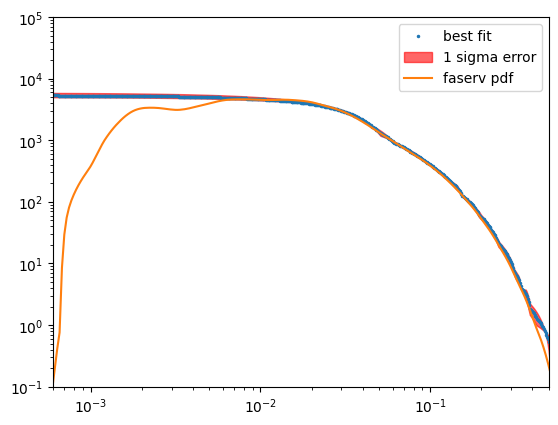

In [13]:
mean_neutrino_fit = np.mean(neutrino_pdfs,axis=0)
error_neutrino_fit = np.std(neutrino_pdfs,axis=0) 
plt.plot(x_fit,mean_neutrino_fit,'o',label="best fit",markersize=1.5)
plt.fill_between(x_fit,mean_neutrino_fit+error_neutrino_fit,mean_neutrino_fit-error_neutrino_fit,label='1 sigma error',color = 'red',alpha=0.6)
plt.plot(x_faser,faser_pdf,label ='faserv pdf')
plt.ylim(10**-1,10**5)
plt.xlim(6*10**-4,0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('neutrino_fit.pdf')
plt.show()


/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_4281/605914053.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(x_faser,faser_pdf/faser_pdf,label ='faserv pdf')


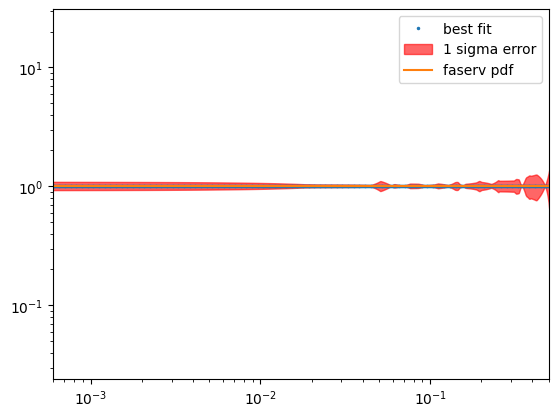

In [14]:
plt.plot(x_fit,mean_neutrino_fit/mean_neutrino_fit,'o',label="best fit",markersize=1.5)
plt.fill_between(x_fit,(mean_neutrino_fit+error_neutrino_fit)/mean_neutrino_fit,(mean_neutrino_fit-error_neutrino_fit)/mean_neutrino_fit,label='1 sigma error',color = 'red',alpha=0.6)
plt.plot(x_faser,faser_pdf/faser_pdf,label ='faserv pdf')
# plt.ylim(10**-1,10**5)
plt.xlim(6*10**-4,0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend()
# plt.savefig('neutrino_fit.pdf')
plt.show()


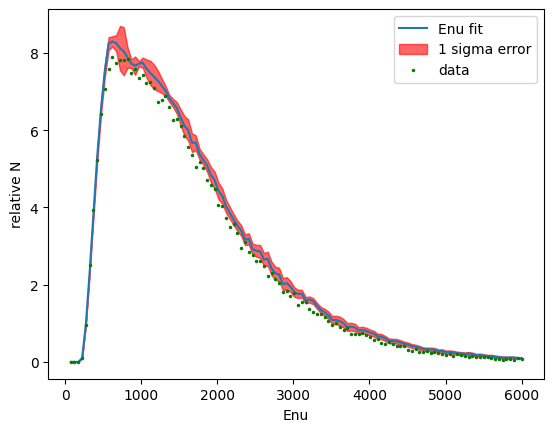

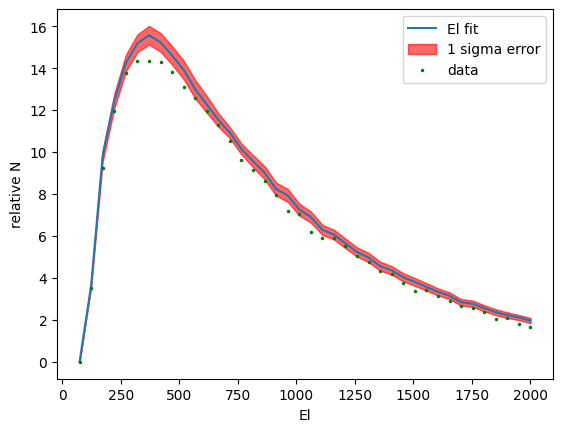

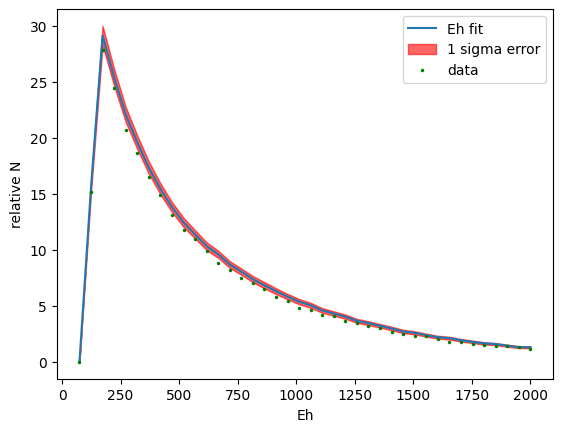

In [15]:
# N_event_pred.append(y_preds.detach().numpy())
mean_N_event_fits = np.mean(N_event_pred,axis=0)
sigma_N_event_fits = np.std(N_event_pred,axis=0)
start = 0
for i in range(num_obs):
    stop = len(xvals_per_obs[i])
    mean_N_event_fit = mean_N_event_fits[start:stop+start] 
    sigma_N_event_fit = sigma_N_event_fits[start:stop+start] 
    plt.plot(xvals_per_obs[i],mean_N_event_fit,label=f"{xlabels[i]} fit")
    
    plt.fill_between(xvals_per_obs[i],(mean_N_event_fit+sigma_N_event_fit),(mean_N_event_fit-sigma_N_event_fit),label='1 sigma error',color = 'red',alpha=0.6)
    
    plt.plot(xvals_per_obs[i],events_per_obs[i],'go',label='data',markersize=1.5)

    plt.xlabel(f'{xlabels[i]}')
    plt.ylabel('relative N')
    
    plt.legend()
    plt.show()
    start += stop

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_4281/400985866.py:7: RuntimeWarning: invalid value encountered in divide
  plt.plot(xvals_per_obs[i],mean_N_event_fit/mean_N_event_fit,label=f"{xlabels[i]} fit")
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_4281/400985866.py:9: RuntimeWarning: invalid value encountered in divide
  plt.fill_between(xvals_per_obs[i],(mean_N_event_fit+sigma_N_event_fit)/mean_N_event_fit,(mean_N_event_fit-sigma_N_event_fit)/mean_N_event_fit,label='1 sigma error',color = 'red',alpha=0.6)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_4281/400985866.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(xvals_per_obs[i],events_per_obs[i]/events_per_obs[i],'go',label='data',markersize=1.5)


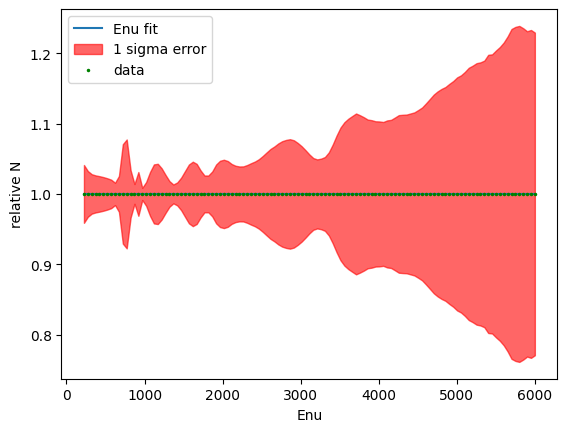

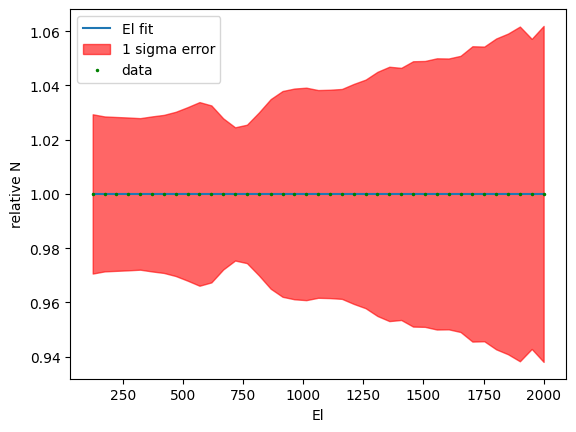

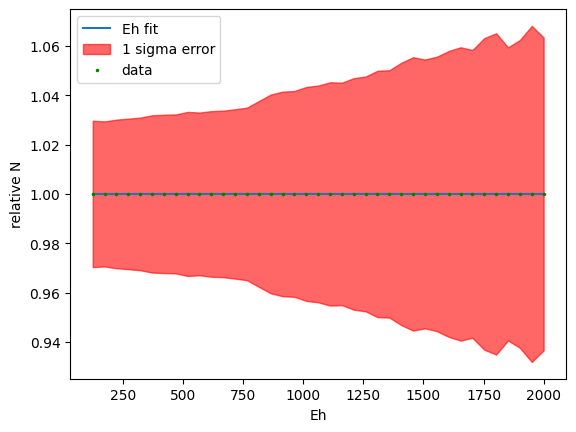

In [16]:
start = 0
for i in range(num_obs):
    stop = len(xvals_per_obs[i])
    mean_N_event_fit = mean_N_event_fits[start:stop+start] 
    sigma_N_event_fit = sigma_N_event_fits[start:stop+start] 
    
    plt.plot(xvals_per_obs[i],mean_N_event_fit/mean_N_event_fit,label=f"{xlabels[i]} fit")
    
    plt.fill_between(xvals_per_obs[i],(mean_N_event_fit+sigma_N_event_fit)/mean_N_event_fit,(mean_N_event_fit-sigma_N_event_fit)/mean_N_event_fit,label='1 sigma error',color = 'red',alpha=0.6)
    
    plt.plot(xvals_per_obs[i],events_per_obs[i]/events_per_obs[i],'go',label='data',markersize=1.5)

    plt.xlabel(f'{xlabels[i]}')
    plt.ylabel('relative N')
    
    plt.legend()
    plt.show()
    start += stop